# Solving Unconstrained Nonlinear Programming Models
## Mehmet Gönen
## November 28, 2022

In [1]:
# load libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

The ```scipy.optimize``` package provides several commonly used optimization algorithms.

## Unconstrained minimization of multivariate scalar functions
The ```minimize``` function provides a common interface to unconstrained and constrained minimization algorithms for multivariate scalar functions in ```scipy.optimize```. To demonstrate the minimization function, consider the problem of minimizing the Rosenbrock function of $N \geq 2$ variables:

$$f\left(\mathbf{x}\right)=\sum\limits_{i=1}^{N-1}\left[100\left(x_{i+1}-x_{i}^{2}\right)^{2}+(1-x_{i})^{2}\right].$$

The minimum value of this function is 0, which is achieved when $x_{i} = 1$.

For $N = 2$ variables, the Rosenbrock function becomes

$$f\left(\begin{bmatrix}x_{1} \\ x_{2}\end{bmatrix}\right)=100\left(x_{2}-x_{1}^{2}\right)^{2}+(1-x_{1})^{2}.$$

In [2]:
def Rosenbrock(x):
    return (100.0 * (x[1] - x[0]**2)**2 + (1 - x[0])**2)

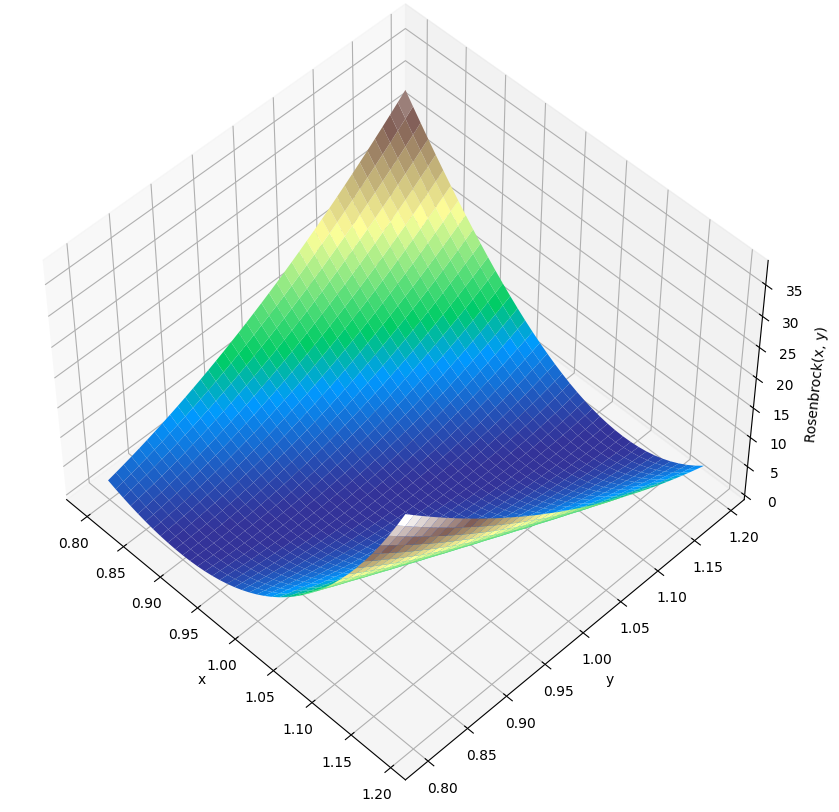

In [3]:
x = np.arange(0.8, 1.2, step = 0.01)
y = np.arange(0.8, 1.2, step = 0.01)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = "3d")
ax.view_init(50, -45)
ax.plot_surface(xgrid, ygrid, Rosenbrock(xy), cmap = "terrain")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Rosenbrock(x, y)")
plt.show()

For $N = 3$ variables, the Rosenbrock function becomes

$$f\left(\begin{bmatrix}x_{1} \\ x_{2} \\ x_{3}\end{bmatrix}\right)=100\left(x_{2}-x_{1}^{2}\right)^{2}+(1-x_{1})^{2} + 100\left(x_{3}-x_{2}^{2}\right)^{2}+(1-x_{2})^{2}.$$

### Nelder-Mead simplex or Powell's method algorithms
In the example below, the ```minimize``` routine is used with the *Nelder-Mead* simplex algorithm (selected through the method parameter):

In [4]:
def Rosenbrock(x):
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

In [5]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = opt.minimize(Rosenbrock, x0, method = "nelder-mead",
                   options = {"xatol": 1e-8, "disp": True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571
[1. 1. 1. 1. 1.]


The simplex algorithm is probably the simplest way to minimize a fairly well-behaved function. It requires only function evaluations and is a good choice for simple minimization problems. However, because it does not use any gradient evaluations, it may take longer to find the minimum.

Another optimization algorithm that needs only function calls to find the minimum is *Powell*’s method available by setting ```method='powell'``` in ```minimize```.

In [6]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = opt.minimize(Rosenbrock, x0, method = "powell",
                   options = {"disp": True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 1084
[1. 1. 1. 1. 1.]


### Broyden-Fletcher-Goldfarb-Shanno algorithm

In order to converge more quickly to the solution, this routine uses the gradient of the objective function. If the gradient is not given by the user, then it is estimated using first-differences. The Broyden-Fletcher-Goldfarb-Shanno (BFGS) method typically requires fewer function calls than the simplex algorithm even when the gradient must be estimated.

To demonstrate this algorithm, the Rosenbrock function is again used. For $N = 2$ variables, the gradient vector can be found as
\begin{align*}
f\left(\begin{bmatrix}x_{1} \\ x_{2}\end{bmatrix}\right)&=100\left(x_{2}-x_{1}^{2}\right)^{2}+(1-x_{1})^{2} \\ 
\frac{\partial f}{\partial x_{1}} &= -400x_{1}\left(x_{2}-x_{1}^{2}\right)-2\left(1-x_{1}\right),\\ 
\frac{\partial f}{\partial x_{2}} &= 200\left(x_{2}-x_{1}^{2}\right).
\end{align*}

For $N = 3$ variables, the gradient vector can be found as
\begin{align*} 
f\left(\begin{bmatrix}x_{1} \\ x_{2} \\ x_{3}\end{bmatrix}\right)&=100\left(x_{2}-x_{1}^{2}\right)^{2}+(1-x_{1})^{2} + 100\left(x_{3}-x_{2}^{2}\right)^{2}+(1-x_{2})^{2}\\
\frac{\partial f}{\partial x_{1}} &= -400x_{1}\left(x_{2}-x_{1}^{2}\right)-2\left(1-x_{1}\right),\\ 
\frac{\partial f}{\partial x_{2}} &= 200\left(x_{2}-x_{1}^{2}\right)-400x_{2}\left(x_{3}-x_{2}^{2}\right)-2\left(1-x_{2}\right),\\
\frac{\partial f}{\partial x_{3}} &= 200\left(x_{3}-x_{2}^{2}\right).
\end{align*}

The gradient of the Rosenbrock function is the vector:
\begin{align*} 
\frac{\partial f}{\partial x_{1}} &= -400x_{1}\left(x_{2}-x_{1}^{2}\right)-2\left(1-x_{1}\right),\\ 
\frac{\partial f}{\partial x_{j}} &= 200\left(x_{j}-x_{j-1}^{2}\right)-400x_{j}\left(x_{j+1}-x_{j}^{2}\right)-2\left(1-x_{j}\right) \;\;\;\; j = 2, \dots, N - 1,\\
\frac{\partial f}{\partial x_{N}} &= 200\left(x_{N}-x_{N-1}^{2}\right).
\end{align*}

A Python function which computes this gradient is constructed by the code-segment:

In [7]:
def Rosenbrock_derivative(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    derivative = np.zeros_like(x)
    derivative[1:-1] = 200 * (xm - xm_m1**2) - 400 * xm * (xm_p1 - xm ** 2) - 2 * (1 - xm)
    derivative[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    derivative[-1] = 200 * (x[-1] - x[-2]**2)
    return derivative

This gradient information is specified in the ```minimize``` function through the *jac* parameter as illustrated below.

In [8]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = opt.minimize(Rosenbrock, x0, method = "BFGS",
                   jac = Rosenbrock_derivative, options = {"disp": True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
[1.00000004 1.0000001  1.00000021 1.00000044 1.00000092]
